# 利用Open AI embedding技術進行自然語言處理應用
- 本程式利用Open AI 提供的embedding函式，將amazon食物評價資料集，轉化成大型語言模型的embedding向量
- 轉化後的amazon食物評價資料集embedding向量，可以進行查詢、叢集、分類...等應用

### 安裝需要的套件
* `openai`
* `transformers`
* `tiktoken`

In [ ]:
!pip install openai -U
!pip install transformers -U
!pip install tiktoken

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 391.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.4

### 引入需要的套件
這邊使用`openai`的`get_embedding`將文字資料轉成文字嵌入

In [ ]:
import pandas as pd
import tiktoken

from openai.embeddings_utils import get_embedding
import openai

### 選擇要使用的embedding模型
* 使用最新版的`ada`
* 選擇encoding的方式，就是tokenizer
* 將最大token值設為8000，預設最大值為8191

In [ ]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

### 上傳資料並且合併文字和評論
* 上傳amazon food review，資料量太大，所以只使用前1000筆。
* 將資料從`csv`讀入`df`中，並且只要固定欄位
* 使用`dropna`將空白欄位移除
* 新增一個欄位，將`"Sumarry"`和`"Text"`合併，稱之為`"Combined"`

In [ ]:
!wget https://github.com/shhuangmust/AI/raw/111-2/fine_food_reviews_1k.csv

--2023-05-18 11:59:07--  https://github.com/shhuangmust/AI/raw/111-2/fine_food_reviews_1k.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shhuangmust/AI/111-2/fine_food_reviews_1k.csv [following]
--2023-05-18 11:59:07--  https://raw.githubusercontent.com/shhuangmust/AI/111-2/fine_food_reviews_1k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 436148 (426K) [text/plain]
Saving to: ‘fine_food_reviews_1k.csv’

fine_food_reviews_1 100%[===================>] 425.93K  --.-KB/s    in 0.01s   

2023-05-18 11:59:07 (33.3 MB/s) - ‘fine_food_reviews_1k.csv’ saved [436148/436148]



In [ ]:
input_datapath = "fine_food_reviews_1k.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


## 只取得1000個，並且將太長的文字去除
* 取得最新的前1000個
* 將較舊的drop掉
* 使用`tiktoken`將文字encoding成需要的何式
* trncate掉太長的


In [ ]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

In [ ]:
openai.api_key = "請輸入你自己的api-key"

### [獲取API key的方式](https://github.com/shhuangmust/AI/blob/111-2/OpenAI%20API%20%E7%8D%B2%E5%8F%96%20API%20Key%E6%96%B9%E5%BC%8F.md)

### 將文字轉成embedding
* 使用`get_embedding`方法
* 這個動作會要花個十分鐘
* <font color=red>**如果沒有api key，可以直接下載已經embedding好的檔案 (改執行下面的wget命令，請把#註解拿掉)**</font>

In [ ]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

In [ ]:
# 如果沒有api key，上一格程式不要執行，改執行下面wget命令
#!wget https://github.com/joshhu/mustgpt2023/raw/main/Code/5/fine_food_reviews_with_embeddings_1k.csv 

### 將Embedding的結果繪製出來
* 先降維

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np

# Load the embeddings
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"
df = pd.read_csv(datafile_path)

# Convert to a list of lists of floats
matrix = np.array(df.embedding.apply(eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(1000, 2)

### 將Embedding的結果繪製出來
* 再畫出來

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

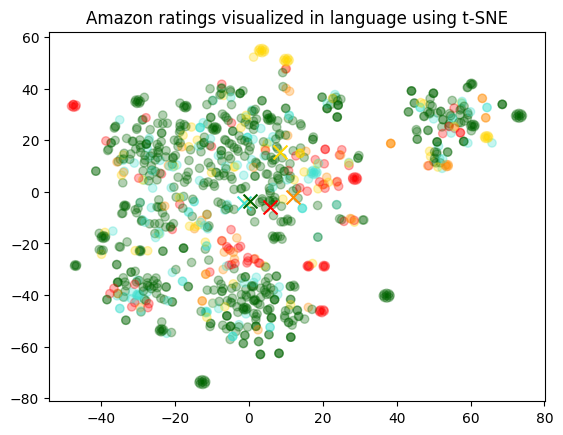

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

### 換成另一個embedding型態
* 此程式常常會當
* <font color=red>**如不想執行，可直接下載檔案 (改執行下面的wget命令，請把#註解拿掉)**</font>

In [ ]:
def get_embedding2(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

df['ada_embedding'] = df.combined.apply(lambda x: get_embedding2(x, model='text-embedding-ada-002'))
df.to_csv('embedded_1k_reviews.csv', index=False)

In [ ]:
# 如果不想執行上一格程式，可改執行下面wget命令
#!wget https://github.com/joshhu/mustgpt2023/raw/main/Code/5/embedded_1k_reviews.csv

### 重新畫一個圖，用新的程式

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

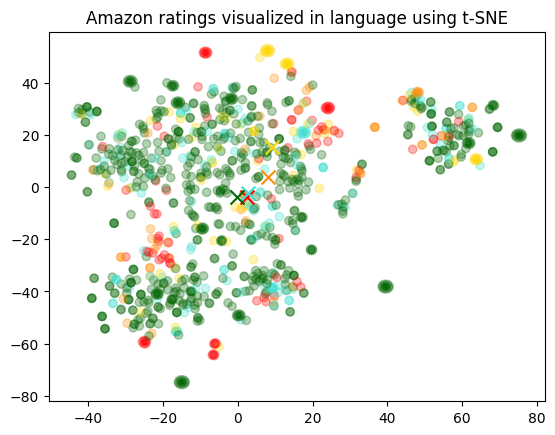

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

df = pd.read_csv('embedded_1k_reviews.csv')
matrix = np.array(df.ada_embedding.apply(eval).to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

vis_dims = tsne.fit_transform(matrix)

colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df.Score.values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
for score in [0,1,2,3,4]:
    avg_x = np.array(x)[df.Score-1==score].mean()
    avg_y = np.array(y)[df.Score-1==score].mean()
    color = colors[score]
    plt.scatter(avg_x, avg_y, marker='x', color=color, s=100)

plt.title("Amazon ratings visualized in language using t-SNE")

### 使用這個embedding來做regression

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

X_train, X_test, y_train, y_test = train_test_split(list(df.embedding.values), df.Score, test_size=0.2, random_state=42)

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)
preds = rfr.predict(X_test)

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"ada-002 embedding performance on 1k Amazon reviews: mse={mse:.2f}, mae={mae:.2f}")

ada-002 embedding performance on 1k Amazon reviews: mse=0.60, mae=0.52


In [ ]:
bmse = mean_squared_error(y_test, np.repeat(y_test.mean(), len(y_test)))
bmae = mean_absolute_error(y_test, np.repeat(y_test.mean(), len(y_test)))
print(
    f"Dummy mean prediction performance on Amazon reviews: mse={bmse:.2f}, mae={bmae:.2f}"
)

Dummy mean prediction performance on Amazon reviews: mse=1.73, mae=1.03


### 用這個embedding來作分類

In [ ]:
# imports
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.Score, test_size=0.2, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           1       0.75      0.30      0.43        20
           2       1.00      0.38      0.55         8
           3       1.00      0.18      0.31        11
           4       1.00      0.26      0.41        27
           5       0.74      1.00      0.85       134

    accuracy                           0.76       200
   macro avg       0.90      0.42      0.51       200
weighted avg       0.80      0.76      0.71       200



### 繪製圖型

RandomForestClassifier() - Average precision score over all classes: 0.88


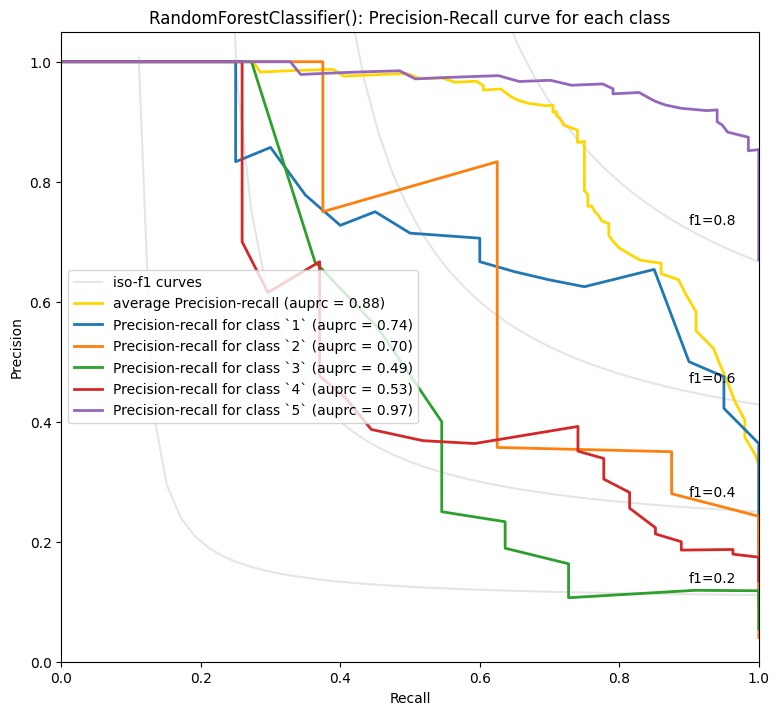

In [ ]:
from openai.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, [1, 2, 3, 4, 5], clf)

### 使用這個embedding來作zero-shot分類任務

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report

# parameters
EMBEDDING_MODEL = "text-embedding-ada-002"

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

<ipython-input-24-327b78491d95>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})


              precision    recall  f1-score   support

    negative       0.61      0.88      0.72       136
    positive       0.98      0.90      0.94       789

    accuracy                           0.90       925
   macro avg       0.79      0.89      0.83       925
weighted avg       0.92      0.90      0.91       925



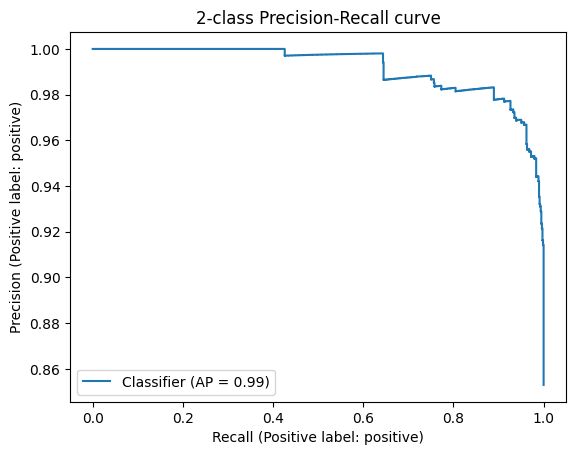

In [ ]:
from openai.embeddings_utils import cosine_similarity, get_embedding
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'], 
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, engine=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach(labels=['negative', 'positive'], model=EMBEDDING_MODEL)

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



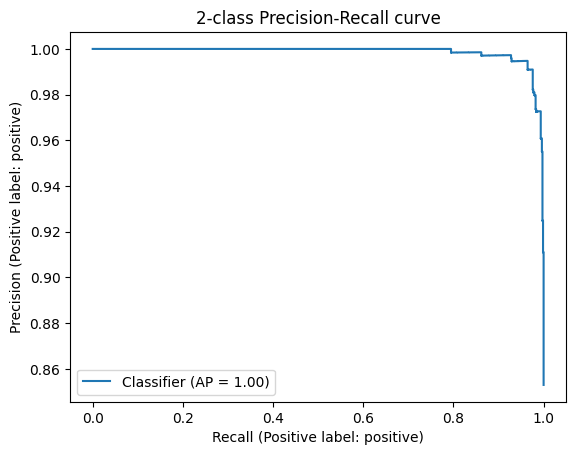

In [ ]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])


              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



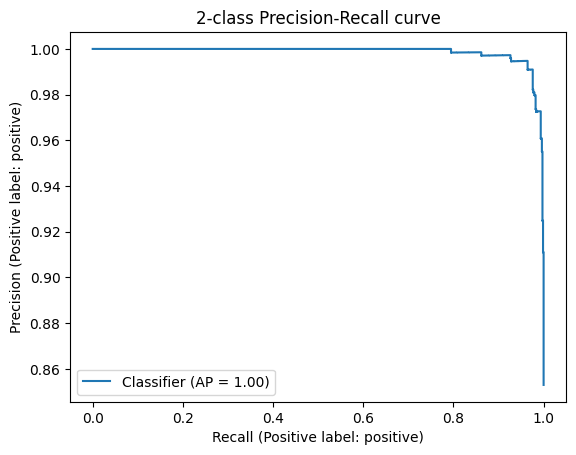

In [ ]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])


### 做clustering

In [ ]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape

(1000, 1536)

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    4.105691
1    4.191176
2    4.215613
3    4.306590
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

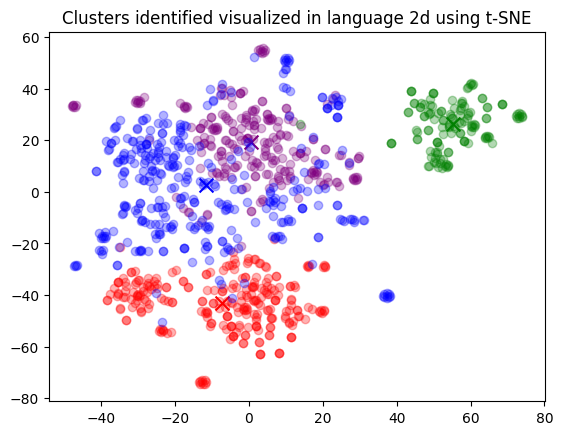

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

### 使用embedding做語義搜尋

In [ ]:
import pandas as pd
import numpy as np

datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

In [ ]:
from openai.embeddings_utils import get_embedding, cosine_similarity

# search through the reviews for a specific product
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results


results = search_reviews(df, "delicious beans", n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [ ]:
results = search_reviews(df, "whole wheat pasta", n=3)

Tasty and Quick Pasta:  Barilla Whole Grain Fusilli with Vegetable Marinara is tasty and has an excellent chunky vegetable marinara.  I just wish there was more of it.  If you aren't starving or on a 

sooo good:  tastes so good. Worth the money. My boyfriend hates wheat pasta and LOVES this. cooks fast tastes great.I love this brand and started buying more of their pastas. Bulk is best.

Handy:  Love the idea of ready in a minute pasta and for that alone this product gets praise.  The pasta is whole grain so that's a big plus and it actually comes out al dente.  The vegetable marinara



In [ ]:
results = search_reviews(df, "bad delivery", n=1)

great product, poor delivery:  The coffee is excellent and I am a repeat buyer.  Problem this time was with the UPS delivery.  They left the box in front of my garage door in the middle of the drivewa



In [ ]:
results = search_reviews(df, "spoilt", n=1)

Extremely dissapointed:  Hi,<br />I am very disappointed with the past shipment I received of the ONE coconut water. 3 of the boxes were leaking and the coconut water was spoiled.<br /><br />Thanks.<b



In [ ]:
results = search_reviews(df, "pet food", n=2)

Good food:  The only dry food my queen cat will eat. Helps prevent hair balls. Good packaging. Arrives promptly. Recommended by a friend who sells pet food.

The cats like it:  My 7 cats like this food but it is a little yucky for the human. Pieces of mackerel swimming in a dark broth. It is billed as a "complete" food and contains carrots, peas and pasta.

